# A. Data processing

## 1. Loading libraries

In [ ]:
!pip install tsnecuda
!pip install -q condacolab
import condacolab
condacolab.install()
!wget https://anaconda.org/CannyLab/tsnecuda/2.1.0/download/linux-64/tsnecuda-2.1.0-cuda101.tar.bz2
!tar xvjf tsnecuda-2.1.0-cuda101.tar.bz2
!cp -r site-packages/* /usr/local/lib/python3.7/dist-packages/
!conda install --offline tsnecuda-2.1.0-cuda101.tar.bz2

In [ ]:
from tsnecuda import TSNE

In [ ]:
%matplotlib inline
import warnings
import numpy as np
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import pylab
import numpy.linalg as la
from collections import Counter
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d import proj3d


from google.colab import drive
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.decomposition import PCA, KernelPCA
from sklearn.cluster import KMeans, DBSCAN 
from sklearn import datasets, svm
from sklearn.ensemble import StackingClassifier, BaggingClassifier, VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from xgboost import XGBClassifier
from skimage.feature import hog
from scipy import stats
import seaborn as sns


warnings.filterwarnings("ignore", category=DeprecationWarning)
# drive.mount('/content/drive')

## 2. Loading Data

In [ ]:
# Download dataset
train_set = torchvision.datasets.FashionMNIST("./data", download=True, transform=
                                                transforms.Compose([transforms.ToTensor()]))
test_set = torchvision.datasets.FashionMNIST("./data", download=True, train=False, transform=
                                               transforms.Compose([transforms.ToTensor()]))
X_train = train_set.data.numpy()
X_test = test_set.data.numpy()
y_train = train_set.targets.numpy()
y_test = test_set.targets.numpy()

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



In [ ]:
# vectorization
X_train = X_train.reshape((len(X_train), -1)) / 255.0
X_test = X_test.reshape((len(X_test), -1)) / 255.0

In [ ]:
class_names = {0:'T-shirt', 1:'Trouser',2: 'Pullover',3: 'Dress',4: 'Coat',5:
               'Sandal',6: 'Shirt', 7:'Sneaker',8:  'Bag',9: 'Ankle boot'}

In [ ]:
hist_train = np.histogram(y_train)[0]
hist_test = np.histogram(y_test)[0]
print(f'train class distribution: {hist_train}')
print(f'test class distribution: {hist_test}')

train class distribution: [6000 6000 6000 6000 6000 6000 6000 6000 6000 6000]
test class distribution: [1000 1000 1000 1000 1000 1000 1000 1000 1000 1000]


# B. Unsupervised Methods

## 1. Principal Component Analysis

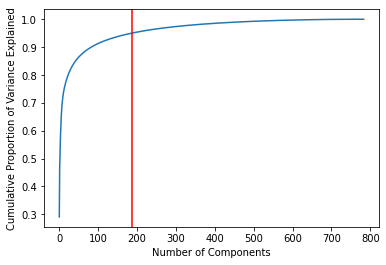

In [ ]:
pca = PCA().fit(X_train)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Proportion of Variance Explained')
plt.axvline(187, 0, 1,color ="red")
plt.show()

In [ ]:
check=np.cumsum(pca.explained_variance_ratio_)
check[275]
## 275 components expain ~97% of variance

0.9698592311103407

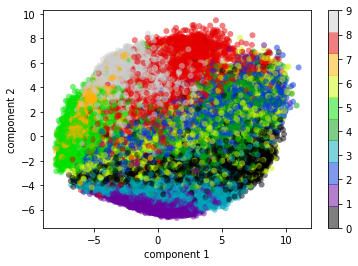

In [ ]:
pc = PCA(2).fit_transform(X_train)
plt.scatter(pc[:, 0], pc[:, 1],
            c=y_train, edgecolor='none', alpha=0.5,
            cmap=plt.cm.get_cmap('nipy_spectral', 10))
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.colorbar()
plt.show()

## 2. K-means Clustering

In [ ]:
pca = PCA(0.95)
X_train_pca = pca.fit_transform(X_train)
n_clusters = 10
kmeans = KMeans(n_clusters=n_clusters, random_state=0)
y_pred = kmeans.fit(X_train_pca).labels_

In [ ]:
def plot_cluster_label_dist(label2cluster, num_cluster):
    f, axs = plt.subplots(int(np.ceil(num_cluster/2)), 2, figsize=(10, 15))
    for i in range(num_cluster):
        labels = y_train[label2cluster[i]]
        freq = Counter(labels)
        axs[i // 2, i % 2].hist(labels, bins=np.arange(11))
        axs[i // 2, i % 2].set_xticks(np.linspace(0.5, 9.5, 10))
        axs[i // 2, i % 2].set_xticklabels(class_names.values(), rotation=45, rotation_mode='anchor')
        print(f'Dominating class for cluster {i}: {freq.most_common(1)[0][0]}')

Dominating class for cluster 0: 4
Dominating class for cluster 1: 5
Dominating class for cluster 2: 1
Dominating class for cluster 3: 9
Dominating class for cluster 4: 6
Dominating class for cluster 5: 8
Dominating class for cluster 6: 8
Dominating class for cluster 7: 9
Dominating class for cluster 8: 0
Dominating class for cluster 9: 7


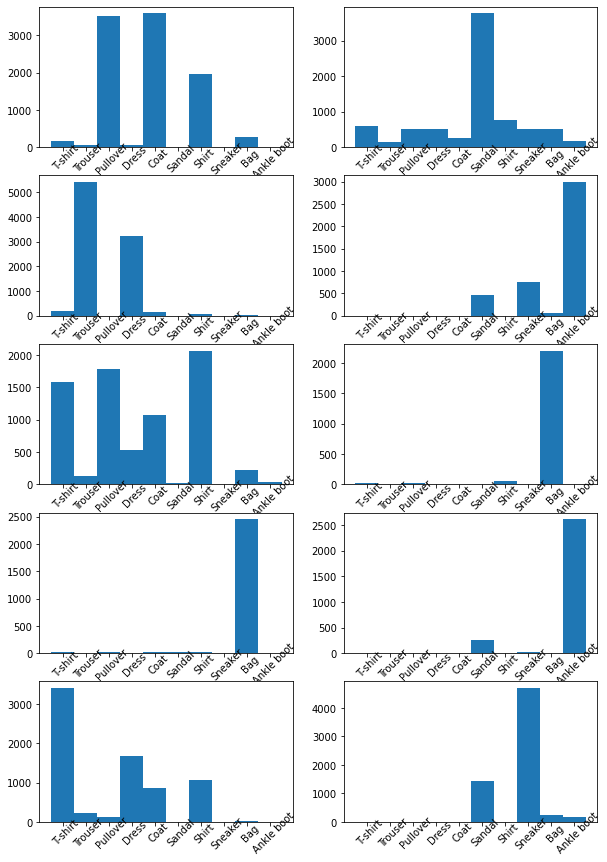

In [ ]:
cluster_assignment = [np.where(y_pred == i)[0] for i in range(n_clusters)]
plot_cluster_label_dist(cluster_assignment, n_clusters)

## 3. DBSCAN

In [ ]:
pca = PCA(150)
scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)
X_train_std_pca = pca.fit_transform(X_train_std)
db = DBSCAN(eps=8, min_samples=20, n_jobs=-1).fit(X_train_std_pca)
labels_db = db.labels_
n_clusters_db = len(set(labels_db)) - (1 if -1 in labels_db else 0)
print(f'DBSCAN num clusters: {n_clusters_db}')

DBSCAN num clusters: 15


Dominating class for cluster 0: 1
Dominating class for cluster 1: 4
Dominating class for cluster 2: 9
Dominating class for cluster 3: 4
Dominating class for cluster 4: 0
Dominating class for cluster 5: 7
Dominating class for cluster 6: 3
Dominating class for cluster 7: 1
Dominating class for cluster 8: 9
Dominating class for cluster 9: 2
Dominating class for cluster 10: 9
Dominating class for cluster 11: 4
Dominating class for cluster 12: 1
Dominating class for cluster 13: 9
Dominating class for cluster 14: 3


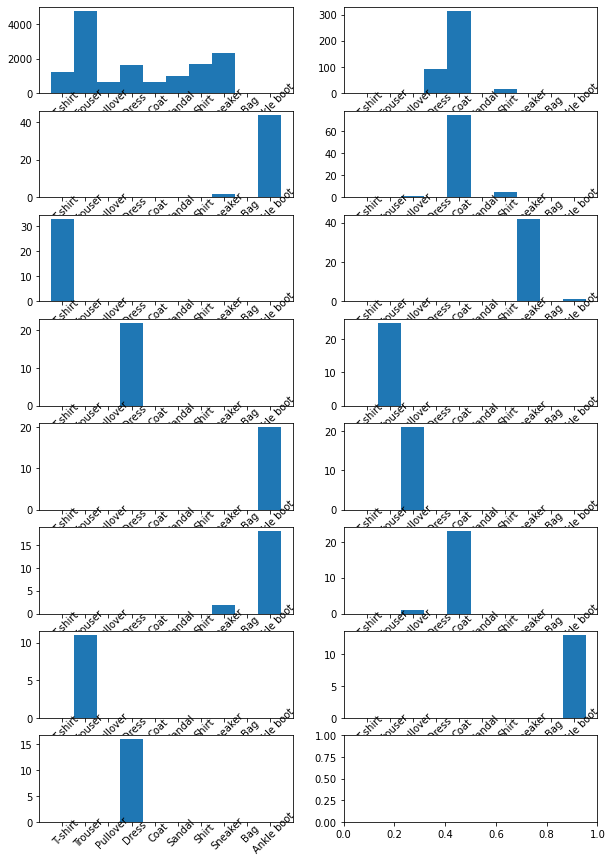

In [ ]:
db_assignment = [np.where(labels_db == i)[0] for i in range(n_clusters_db)]
plot_cluster_label_dist(db_assignment, n_clusters_db)

## 4. t-SNE

In [ ]:
tsne = TSNE(n_components=2).fit_transform(PCA(0.95).fit_transform(X_train))

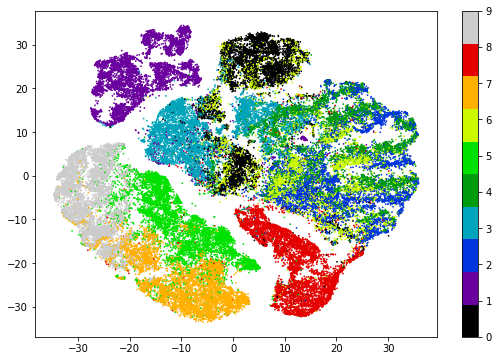

In [ ]:
plt.figure(figsize=(9, 6))
plt.scatter(tsne[:, 0], tsne[:, 1], c=y_train, s=0.5, cmap=plt.cm.get_cmap('nipy_spectral', 10))
plt.colorbar()
plt.show()

In [ ]:
# TODO perform clustering on TSNE embedding

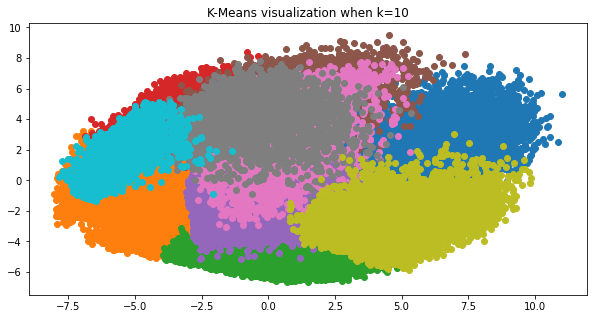

In [ ]:
# dimensionity reduction for visualization purposes
kmeans_pca = PCA(2)
X_train_kmeans_pca = kmeans_pca.fit_transform(X_train)
filtered_labels = [X_train_kmeans_pca[y_pred == i] for i in range(len(np.unique(kmeans.labels_)))]
colors = np.random.rand(len(filtered_labels))

# plot results
plt.figure(figsize=(10,5))
for i in range(len(filtered_labels)):
    plt.scatter(filtered_labels[i][:,0] , filtered_labels[i][:,1])
plt.title("K-Means visualization when k=10")
plt.show()

# C. Multi-class Classification Model


I. Preparing PCA-reduced data (explaining 95% variation)

In [ ]:
pca = PCA(0.95)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

II. Preparing PCA-reduced data on HOG features (explaining 95% variation)

In [ ]:
X_train_im = X_train.reshape((-1, 28, 28)) / 255.0
X_test_im = X_test.reshape((-1, 28, 28)) / 255.0
X_train_hog = np.array([hog(image, pixels_per_cell=(4, 4), cells_per_block=(2, 2)) for image in X_train_im])
X_test_hog = np.array([hog(image, pixels_per_cell=(4, 4), cells_per_block=(2, 2)) for image in X_test_im])

In [ ]:
pca = PCA(0.95)
X_train_hog_pca = pca.fit_transform(X_train_hog)
X_test_hog_pca = pca.transform(X_test_hog)

## 1. Random Forest

In [ ]:
# Model 1
# score 0.8779 (full)
# score 0.8587 (PCA)
clf1 = RandomForestClassifier(criterion="entropy", max_depth=50, n_estimators=100)
clf1.fit(X_train_pca, y_train)
y_pred1 = clf1.predict(X_test_pca)
clf1.score(X_test_pca, y_test)

0.8587

In [ ]:
confusion_matrix(y_pred1, y_test)

array([[865,   8,  17,  39,   2,   0, 179,   0,   3,   0],
       [  0, 953,   0,   4,   0,   0,   0,   0,   0,   0],
       [ 18,   4, 796,   8, 108,   0, 127,   0,   2,   0],
       [ 32,  27,  10, 883,  35,   0,  30,   0,   6,   0],
       [  5,   4, 104,  27, 791,   0,  97,   0,   5,   0],
       [  5,   0,   0,   0,   0, 923,   2,  25,   9,  17],
       [ 58,   2,  63,  33,  56,   1, 537,   0,   8,   0],
       [  0,   0,   0,   0,   0,  40,   0, 933,   5,  36],
       [ 17,   2,  10,   6,   8,   4,  28,   0, 960,   1],
       [  0,   0,   0,   0,   0,  32,   0,  42,   2, 946]])

In [ ]:
clf6 = RandomForestClassifier(criterion="entropy", max_depth=50, n_estimators=100)
clf6.fit(X_train_hog_pca, y_train)
y_pred6 = clf6.predict(X_test_hog_pca)
clf6.score(X_test_hog_pca, y_test)

0.8559

In [ ]:
param_grid = {'max_depth': [10, 50, 70],
              'min_samples_split': [2, 5, 10]}
rf = RandomForestClassifier(random_state=0)

sh = RandomizedSearchCV(rf, param_grid, cv=3).fit(X_train_hog_pca, y_train)
sh.best_estimator_

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:296: UserWarning: The total space of parameters 9 is smaller than n_iter=10. Running 9 iterations. For exhaustive searches, use GridSearchCV.
  UserWarning,


RandomForestClassifier(max_depth=50, min_samples_split=10, random_state=0)

In [ ]:
best_rf = RandomForestClassifier(max_depth=50, min_samples_split=10, random_state=0)
best_rf.fit(X_train_hog_pca, y_train)
best_rf.score(X_test_hog_pca, y_test)

0.8568

In [ ]:
pred_best_rf = best_rf.predict(X_test_hog_pca)
f1_score(pred_best_rf, y_test,average='macro')

## 2. SVM

In [ ]:
# Model 2
# score: 0.8808 (full)
# score: 0.8975 (PCA)
clf2 = svm.SVC(C=10, kernel='poly')
clf2.fit(X_train_pca, y_train)
y_pred2 = clf2.predict(X_test_pca)
clf2.score(X_test_pca, y_test)

0.8975

In [ ]:
confusion_matrix(y_pred2, y_test)

array([[844,   4,  24,  17,   3,   0, 113,   0,   3,   0],
       [  1, 971,   2,   7,   0,   0,   1,   0,   0,   0],
       [ 16,   1, 826,  15,  85,   0,  83,   0,   5,   0],
       [ 19,  17,   5, 905,  19,   0,  24,   0,   6,   0],
       [  3,   3,  76,  25, 832,   0,  51,   0,   3,   0],
       [  0,   0,   0,   0,   0, 967,   0,   8,   1,   4],
       [111,   4,  67,  28,  61,   0, 719,   0,   6,   1],
       [  0,   0,   0,   0,   0,  17,   0, 977,   3,  34],
       [  6,   0,   0,   3,   0,   0,   9,   0, 973,   0],
       [  0,   0,   0,   0,   0,  16,   0,  15,   0, 961]])

In [ ]:
clf5 = svm.SVC(C=100, kernel='poly')
clf5.fit(X_train_hog_pca, y_train)
y_pred5 = clf5.predict(X_test_hog_pca)
clf5.score(X_test_hog_pca, y_test)

0.914

In [ ]:
conf5 = confusion_matrix(y_pred5, y_test)
conf5

array([[859,   2,   6,   7,   1,   0,  99,   0,   1,   0],
       [  2, 972,   0,   6,   0,   0,   2,   0,   1,   0],
       [ 16,   0, 855,   6,  36,   0,  58,   0,   1,   0],
       [ 11,  17,   9, 924,  27,   0,  25,   0,   2,   0],
       [  3,   1,  51,  24, 880,   0,  51,   0,   1,   0],
       [  0,   0,   0,   0,   0, 972,   0,  16,   2,   4],
       [107,   7,  78,  31,  54,   0, 760,   0,   9,   1],
       [  0,   0,   0,   0,   0,  23,   0, 969,   1,  28],
       [  2,   1,   1,   2,   2,   0,   5,   0, 982,   0],
       [  0,   0,   0,   0,   0,   5,   0,  15,   0, 967]])

In [ ]:
sns.set(rc={'figure.figsize':(11,8)})
fig = sns.heatmap(conf5, annot=True, fmt='.2f', cmap='Blues')
fig.set(xlabel='Predicted', ylabel='Ground Truth', title='Confusion Matrix')

In [ ]:
dist = {"C": stats.uniform(10, 100),
        "kernel": ['poly', 'rbf', 'sigmoid']}
rcv = RandomizedSearchCV(svm.SVC(), dist, n_iter=3, n_jobs=-1, random_state=0)
result = rcv.fit(X_train_hog_pca, y_train)
result.best_params_

{'C': 64.88135039273247, 'kernel': 'rbf'}

In [ ]:
param_grid = [
    {"kernel": ["rbf"], "C": [10, 50, 100]},
    {"kernel": ["poly"], "C": [10, 50, 100]},
    {"kernel": ["sigmoid"], "C": [10, 50, 100]}
]
clf_cv = GridSearchCV(svm.SVC(), param_grid, n_jobs=-1, scoring="accuracy")
clf_cv.fit(X_train_hog_pca, y_train)
clf_cv.best_params_

{'C': 10, 'kernel': 'poly'}

In [ ]:
svm_rcv = svm.SVC(C=64.88, kernel='rbf')
svm_rcv.fit(X_train_hog_pca, y_train)
svm_rcv.score(X_test_hog_pca, y_test)

0.9139

In [ ]:
svm_rcv_pred = svm_rcv.predict(X_test_hog_pca)
f1_score(svm_rcv_pred, y_test, average='macro')

0.9137044788676846

In [ ]:
svm_gcv = svm.SVC(C=10, kernel='poly')
svm_gcv.fit(X_train_hog_pca, y_train)
svm_gcv.score(X_test_hog_pca, y_test)

0.9138

## 3. Logistic Regression

In [ ]:
# Model 3
# score: 0.8377 (full)
# score: 0.8414 (PCA)
clf3 = LogisticRegression(C=1, multi_class="ovr", penalty = "l1", solver="saga")
clf3.fit(X_train_pca, y_train)
y_pred3 = clf3.predict(X_test_pca)
clf3.score(X_test_pca, y_test)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter

0.8414

In [ ]:
confusion_matrix(y_pred3, y_test)

array([[816,   5,  21,  30,   0,   2, 151,   0,   5,   0],
       [  2, 955,   4,  15,   1,   0,   2,   0,   1,   0],
       [ 16,   4, 735,   9, 108,   0, 137,   0,   3,   0],
       [ 51,  27,  10, 877,  41,   1,  46,   0,  12,   0],
       [  5,   4, 137,  28, 757,   0, 104,   0,   3,   0],
       [  3,   0,   0,   0,   0, 917,   0,  34,   7,  16],
       [ 93,   2,  80,  38,  83,   0, 529,   0,  13,   0],
       [  1,   1,   1,   0,   0,  51,   0, 933,   6,  38],
       [ 13,   2,  11,   3,  10,   8,  31,   1, 950,   1],
       [  0,   0,   1,   0,   0,  21,   0,  32,   0, 945]])

In [ ]:
clf7 = LogisticRegression(C=1, multi_class="ovr", penalty = "l1", solver="saga")
clf7.fit(X_train_hog_pca, y_train)
y_pred7 = clf7.predict(X_test_hog_pca)
clf7.score(X_test_hog_pca, y_test)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


0.8801

## 4. XGBoost 

In [ ]:
# Model 4
# score: 0.8582 (full)
# score: 0.8288 (PCA)

TREE_METHOD = 'gpu_hist'
clf4 = XGBClassifier(tree_method=TREE_METHOD) 
clf4.fit(X_train_pca, y_train)
y_pred4 = clf4.predict(X_test_pca)
clf4.score(X_test_pca, y_test)

0.8288

In [ ]:
confusion_matrix(y_pred4, y_test)

array([[823,   5,  16,  34,   0,   0, 203,   0,   5,   0],
       [  1, 951,   1,  11,   2,   0,   0,   0,   0,   0],
       [ 18,   8, 732,   7,  97,   0, 132,   0,  12,   0],
       [ 55,  31,   8, 871,  42,   1,  38,   0,   9,   0],
       [ 10,   2, 133,  31, 760,   0, 108,   0,   4,   0],
       [  5,   0,   2,   1,   4, 892,   1,  39,  11,  19],
       [ 71,   1,  97,  41,  88,   0, 492,   0,  19,   0],
       [  0,   0,   0,   0,   0,  62,   0, 901,  11,  39],
       [ 17,   2,  11,   3,   7,   5,  26,   2, 925,   1],
       [  0,   0,   0,   1,   0,  40,   0,  58,   4, 941]])

In [ ]:
TREE_METHOD = 'gpu_hist'
params = {
    'min_child_weight': range(1,10,2),
    'max_depth': range(1,10,2),
    'gamma': np.arange(0,0.5,0.1),
    'subsample': np.arange(0.5,0.9,0.1),
    'colsample_bytree': np.arange(0.5,0.9,0.1),
    'n_estimators': range(100,1001,100)
}

clf6 = XGBClassifier(tree_method=TREE_METHOD) 
cv = RandomizedSearchCV(clf6, param_distributions=params, n_iter=100, cv=10, n_jobs=-1, verbose=10)
cv.fit(X_train_hog_pca, y_train)
cv.best_params_

Fitting 10 folds for each of 100 candidates, totalling 1000 fits


In [ ]:
cv.score(X_train_hog_pca, y_train)

# D. Ensemble Model 

## 1. Stacking Classifier

In [ ]:
# Ensemble model
# score: 0.8933 (without XGBoost)
# score now: 
estimators = [
    ('rf', clf1),
    ('svc', clf2),
    ('xgboost', clf4)
]

clf = StackingClassifier(
    estimators=estimators, final_estimator=LogisticRegression()
)
clf.fit(X_train, y_train)
clf.score(X_test, y_test)

In [ ]:
estimators = [
    ('rf', RandomForestClassifier(criterion="entropy", max_depth=50, n_estimators=100)),
    ('svc', svm.SVC(C=10, kernel='poly', probability=True)),
]
lf = StackingClassifier(
    estimators=estimators, final_estimator=LogisticRegression()
)
clf = StackingClassifier(
    estimators=estimators, final_estimator=LogisticRegression()
)
clf.fit(X_train_hog_pca, y_train)
clf.score(X_test_hog_pca, y_test)

## 2. Voting Classifier

In [ ]:
model1 = RandomForestClassifier(criterion="entropy", max_depth=50, n_estimators=100)
model2 = KNeighborsClassifier(n_neighbors=7, weights='distance', p=1)
model3 = svm.SVC(C=10, kernel='poly', probability=True)
ensemble = VotingClassifier(estimators=[('dt', model1), ('knn', model2), ('svc', model3)], voting='soft', weights=[1.5, 1, 2])
ensemble.fit(X_train_hog_pca, y_train)
ensemble.score(X_test_hog_pca, y_test)

0.9121

# E. Extra

## 1. Feature Importance using Random Forest

In [ ]:
# First we build and train our Random Forest Model 
import pandas as pd

rf = RandomForestClassifier(criterion="entropy", max_depth=50, n_estimators=100).fit(X_train, y_train)
# rf.feature_importances_

In [ ]:
feature_importances = pd.DataFrame(rf.feature_importances_,  columns=['importance']).sort_values('importance', ascending=False)
feature_importances

,importance
122,1.655260e-02
94,1.311764e-02
150,1.125200e-02
231,1.050190e-02
123,9.685204e-03
...,...
28,1.397628e-06
756,8.931078e-07
26,7.082502e-07
0,6.234100e-07


## 2. Feature Importance using KNN

In [ ]:
from sklearn.inspection import permutation_importance
from matplotlib import pyplot as pyplot

knn = KNeighborsClassifier(n_neighbors=7, weights='distance', p=1).fit(X_train, y_train)
results = permutation_importance(knn, X_train, y_train, scoring='accuracy')
importance = results.importances_mean

# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
 
# plot feature importance
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()

In [ ]:
from xgboost import XGBClassifier

xgbooost = XGBClassifier().fit(X_train, y_train)
importance_xgb = xgbooost.feature_importances_

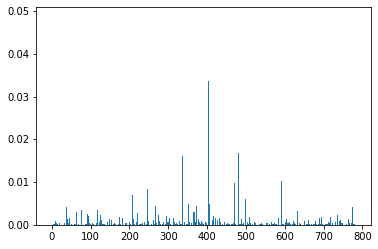

In [ ]:
import matplotlib.pyplot as plt
plt.bar([x for x in range(len(importance_xgb))], importance_xgb)
plt.show()

## 3. Feature Importance using XGBoost

In [ ]:
import pandas as pd
xgb_importances = pd.DataFrame(importance_xgb,  columns=['importance']).sort_values('importance', ascending=False)
xgb_importances

,importance
627,0.048466
490,0.040867
404,0.033634
655,0.027878
346,0.026395
...,...
185,0.000000
184,0.000000
170,0.000000
169,0.000000
